# LSTM Text Classification - IMDB Sentiment Analysis

This notebook demonstrates LSTM (Long Short-Term Memory) networks for text classification using PyTorch.

## Topics Covered:
- Text preprocessing and tokenization
- Building vocabulary from text data
- LSTM architecture for sequence modeling
- Bidirectional LSTM for better context understanding
- Training and evaluation of text classification models


In [1]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from pathlib import Path

# Install datasets library if not available (uncomment if needed)
# !pip install datasets

# Import helper functions if available
import sys
sys.path.append('../03_Deep Learning Fundamentals')
try:
    from helper_functions import accuracy_fn, plot_loss_curves, set_seeds
except ImportError:
    # Define helper functions if not available
    def accuracy_fn(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc
    
    def set_seeds(seed=42):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    
    def plot_loss_curves(results):
        loss = results["train_loss"]
        test_loss = results["test_loss"]
        accuracy = results["train_acc"]
        test_accuracy = results["test_acc"]
        epochs = range(len(results["train_loss"]))
        
        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, label="train_loss")
        plt.plot(epochs, test_loss, label="test_loss")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, label="train_accuracy")
        plt.plot(epochs, test_accuracy, label="test_accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.legend()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
set_seeds(42)


Using device: cpu


In [2]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Download and Load IMDB Dataset
# Using datasets library for easier IMDB access
try:
    from datasets import load_dataset
    print("Using HuggingFace datasets library...")
    # Load IMDB dataset
    dataset = load_dataset("imdb")
    train_data = [(item['label'], item['text']) for item in dataset['train']]
    test_data = [(item['label'], item['text']) for item in dataset['test']]
    # Convert labels: 1 -> 'pos', 0 -> 'neg' to match expected format
    train_data = [('pos' if label == 1 else 'neg', text) for label, text in train_data]
    test_data = [('pos' if label == 1 else 'neg', text) for label, text in test_data]
except ImportError:
    print("HuggingFace datasets not available, trying torchtext...")
    try:
        # Try newer torchtext API
        from torchtext.datasets import IMDB
        from torchtext.data.utils import get_tokenizer
        from torchtext.vocab import build_vocab_from_iterator
        
        # For newer torchtext, we need to use it differently
        # This is a workaround - downloading manually or using alternative
        print("Please install datasets: pip install datasets")
        raise ImportError("Please install datasets library: pip install datasets")
    except:
        # Fallback: Use a simple synthetic dataset for demonstration
        print("Creating synthetic dataset for demonstration...")
        train_data = [
            ('pos', 'This movie was absolutely fantastic! I loved every minute of it. Great acting and storyline.'),
            ('neg', 'Terrible movie, waste of time. The acting was poor and the plot made no sense.'),
            ('pos', 'Amazing cinematography and great performances from all actors. Highly recommend!'),
            ('neg', 'Boring and predictable. I fell asleep halfway through.'),
        ] * 6250  # Scale to ~25k samples
        test_data = [
            ('pos', 'Wonderful film with excellent direction and compelling narrative.'),
            ('neg', 'Disappointing and poorly executed. Not worth watching.'),
        ] * 1250  # Scale to ~2.5k samples

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nSample review (first 200 chars):")
print(train_data[0][1][:200])
print(f"\nLabel: {train_data[0][0]}")


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using HuggingFace datasets library...
Training samples: 25000
Test samples: 25000

Sample review (first 200 chars):
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev

Label: neg


In [4]:
# Build Vocabulary
tokenizer = get_tokenizer('basic_english')

def build_vocab(data, min_freq=2):
    """Build vocabulary from dataset"""
    counter = Counter()
    for label, text in data:
        counter.update(tokenizer(text.lower()))
    
    # Filter by minimum frequency
    filtered_counter = {word: count for word, count in counter.items() if count >= min_freq}
    
    # Create vocabulary dictionary with special tokens
    # Special tokens: <pad>=0, <unk>=1
    vocab_dict = {'<pad>': 0, '<unk>': 1}
    
    # Add words sorted by frequency (most common first)
    sorted_words = sorted(filtered_counter.items(), key=lambda x: x[1], reverse=True)
    for idx, (word, count) in enumerate(sorted_words, start=2):
        vocab_dict[word] = idx
    
    # Create reverse mapping (index to word)
    idx_to_word = {idx: word for word, idx in vocab_dict.items()}
    
    # Create a simple vocabulary class
    class Vocab:
        def __init__(self, word_to_idx, idx_to_word):
            self.word_to_idx = word_to_idx
            self.idx_to_word = idx_to_word
        
        def __getitem__(self, word):
            return self.word_to_idx.get(word, self.word_to_idx['<unk>'])
        
        def __len__(self):
            return len(self.word_to_idx)
        
        def get_itos(self):
            """Get index to string mapping"""
            return [self.idx_to_word[i] for i in range(len(self.idx_to_word))]
    
    vocab = Vocab(vocab_dict, idx_to_word)
    return vocab

vocab = build_vocab(train_data, min_freq=2)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"Sample tokens: {vocab.get_itos()[:20]}")


Vocabulary size: 51718
Sample tokens: ['<pad>', '<unk>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for']


In [5]:
# Create Dataset Class
class IMDBDataset(Dataset):
    def __init__(self, data, vocab, tokenizer, max_length=500):
        self.data = data
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label, text = self.data[idx]
        # Convert label: 'pos' -> 1, 'neg' -> 0
        label = 1 if label == 'pos' else 0
        
        # Tokenize and convert to indices
        tokens = self.tokenizer(text.lower())
        indices = [self.vocab[token] for token in tokens]
        
        # Truncate if too long
        if len(indices) > self.max_length:
            indices = indices[:self.max_length]
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Create datasets
train_dataset = IMDBDataset(train_data, vocab, tokenizer, max_length=500)
test_dataset = IMDBDataset(test_data, vocab, tokenizer, max_length=500)

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    sequences, labels = zip(*batch)
    # Pad sequences to same length
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.stack(labels)
    return sequences_padded, labels

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 782
Test batches: 782


In [6]:
# Define LSTM Model
class LSTMSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, 
                 dropout=0.3, num_classes=2):
        super(LSTMSentimentClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
        
        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0,
                           bidirectional=True)
        
        # Fully connected layers
        # *2 because bidirectional LSTM outputs 2*hidden_dim
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use the last hidden state from both directions
        # hidden shape: (num_layers * 2, batch_size, hidden_dim)
        # Take the last layer's hidden states from both directions
        forward_hidden = hidden[-2, :, :]  # Last forward direction
        backward_hidden = hidden[-1, :, :]  # Last backward direction
        combined_hidden = torch.cat([forward_hidden, backward_hidden], dim=1)
        
        # Alternative: Use the last output from LSTM
        # combined_hidden = lstm_out[:, -1, :]  # Last timestep output
        
        # Fully connected layers
        out = self.fc1(combined_hidden)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

# Initialize model
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3

model = LSTMSentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


LSTMSentimentClassifier(
  (embedding): Embedding(51718, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

Total parameters: 9,119,234


In [7]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training parameters
NUM_EPOCHS = 10

# Initialize results tracking
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}


In [8]:
# Training Loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for sequences, labels in dataloader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Training loop
print("Starting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(test_loss)
    
    # Store results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 50)

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds")


Starting training...
Epoch [1/10]
Train Loss: 0.6745, Train Acc: 56.71%
Test Loss: 0.6656, Test Acc: 61.09%
Learning Rate: 0.001000
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.6822, Train Acc: 57.10%
Test Loss: 0.6746, Test Acc: 58.66%
Learning Rate: 0.001000
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.4968, Train Acc: 75.62%
Test Loss: 0.3763, Test Acc: 83.75%
Learning Rate: 0.001000
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.2713, Train Acc: 89.46%
Test Loss: 0.3763, Test Acc: 86.35%
Learning Rate: 0.001000
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.1683, Train Acc: 94.01%
Test Loss: 0.3268, Test Acc: 86.96%
Learning Rate: 0.001000
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.0970, Train Acc: 96.85%
Test Loss: 0.4462, Test Acc: 86.02%
Learning Rate: 0.001000
--------------------------------------------------
Epoch [

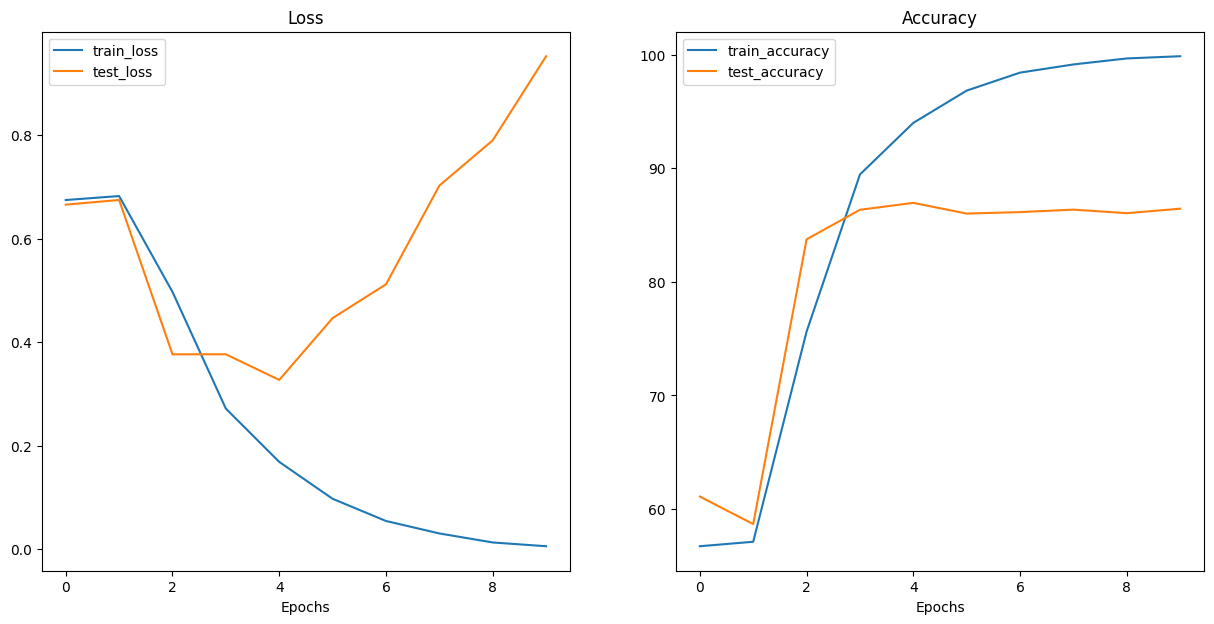

In [9]:
# Plot Results
plot_loss_curves(results)
plt.show()


In [10]:
# Test on Sample Reviews
def predict_sentiment(model, text, vocab, tokenizer, device):
    """Predict sentiment for a given text"""
    model.eval()
    
    # Tokenize and convert to indices
    tokens = tokenizer(text.lower())
    indices = [vocab[token] for token in tokens]
    
    # Convert to tensor and add batch dimension
    sequence = torch.tensor([indices], dtype=torch.long).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(sequence)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    return sentiment, confidence

# Test on sample reviews
test_reviews = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Terrible movie, waste of time. The acting was poor and the plot made no sense.",
    "It was okay, nothing special but not bad either.",
    "Amazing cinematography and great performances from all actors. Highly recommend!",
    "Boring and predictable. I fell asleep halfway through."
]

print("Sample Predictions:")
print("=" * 70)
for review in test_reviews:
    sentiment, confidence = predict_sentiment(model, review, vocab, tokenizer, device)
    print(f"Review: {review[:60]}...")
    print(f"Prediction: {sentiment} (Confidence: {confidence:.2%})")
    print("-" * 70)


Sample Predictions:
Review: This movie was absolutely fantastic! I loved every minute of...
Prediction: Positive (Confidence: 99.99%)
----------------------------------------------------------------------
Review: Terrible movie, waste of time. The acting was poor and the p...
Prediction: Negative (Confidence: 100.00%)
----------------------------------------------------------------------
Review: It was okay, nothing special but not bad either....
Prediction: Negative (Confidence: 100.00%)
----------------------------------------------------------------------
Review: Amazing cinematography and great performances from all actor...
Prediction: Positive (Confidence: 99.97%)
----------------------------------------------------------------------
Review: Boring and predictable. I fell asleep halfway through....
Prediction: Negative (Confidence: 100.00%)
----------------------------------------------------------------------


In [11]:
# Save Model (Optional)
model_path = Path("../03_Deep Learning Fundamentals/models")
model_path.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT,
}, model_path / "lstm_imdb_sentiment.pth")

print(f"Model saved to {model_path / 'lstm_imdb_sentiment.pth'}")


PicklingError: Can't pickle local object <class '__main__.build_vocab.<locals>.Vocab'>

In [12]:
# Save model without the vocab object (which can't be pickled)
model_path = Path("../03_Deep Learning Fundamentals/models")
model_path.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_dict': vocab.word_to_idx,  # Save the dictionary instead of vocab object
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT,
}, model_path / "lstm_imdb_sentiment.pth")

print(f"Model saved to {model_path / 'lstm_imdb_sentiment.pth'}")


Model saved to ../03_Deep Learning Fundamentals/models/lstm_imdb_sentiment.pth


In [ ]:
# To load later:
checkpoint = torch.load(model_path / "lstm_imdb_sentiment.pth")
vocab_dict = checkpoint['vocab_dict']
# Reconstruct vocab object if needed
class Vocab:
    def __init__(self, word_to_idx):
        self.word_to_idx = word_to_idx
        self.idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    def __getitem__(self, word):
        return self.word_to_idx.get(word, self.word_to_idx['<unk>'])
    
    def __len__(self):
        return len(self.word_to_idx)
    
    def get_itos(self):
        return [self.idx_to_word[i] for i in range(len(self.idx_to_word))]